Let's dig in! <br>
I'm always open to suggestions, suggest me if you have any. 

Give me a thumbs up if you liked the notebook. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

np.set_printoptions(suppress=True)

sns.set_palette("dark")
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv("../input/all_data.csv")

In [3]:
data.head()

,timestamp,total_addresses,blocksize,price_USD,hashrate,total_eth_growth,market-cap-value,transactions
0,1.438214e+09,9205.0,644.0,0.0,23.7569,7.204931e+07,7.204931e+07,8893.0
1,1.438301e+09,9361.0,582.0,0.0,48.1584,7.208550e+07,7.208550e+07,0.0
2,1.438387e+09,9476.0,575.0,0.0,55.2709,7.211320e+07,7.211320e+07,0.0
3,1.438474e+09,9563.0,581.0,0.0,64.1779,7.214143e+07,7.214143e+07,0.0
4,1.438560e+09,9639.0,587.0,0.0,69.8559,7.216940e+07,7.216940e+07,0.0


In [4]:
data.dtypes

timestamp           float64
total_addresses     float64
blocksize           float64
price_USD           float64
hashrate            float64
total_eth_growth    float64
market-cap-value    float64
transactions        float64
dtype: object

In [5]:
import datetime as dt
data['date'] = data.apply(lambda x: dt.datetime.fromtimestamp(x['timestamp']), axis = 1)
data['year'] = data.apply(lambda x: dt.datetime.fromtimestamp(x['timestamp']).year, axis = 1)

<h3><center>Transaction patterns. </center></h3>

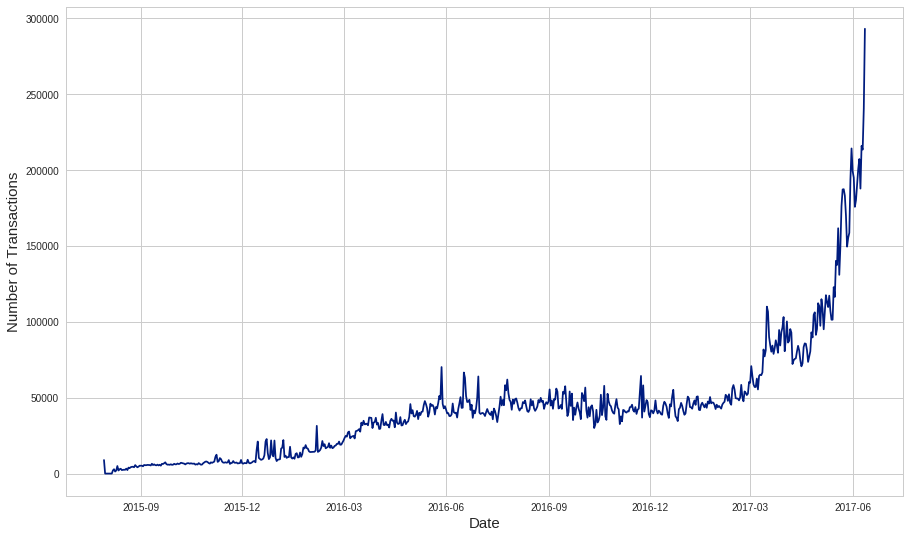

In [6]:
plt.subplots(figsize=(15, 9))
plt.plot(data['date'], data['transactions'])
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Number of Transactions", fontsize = 15)

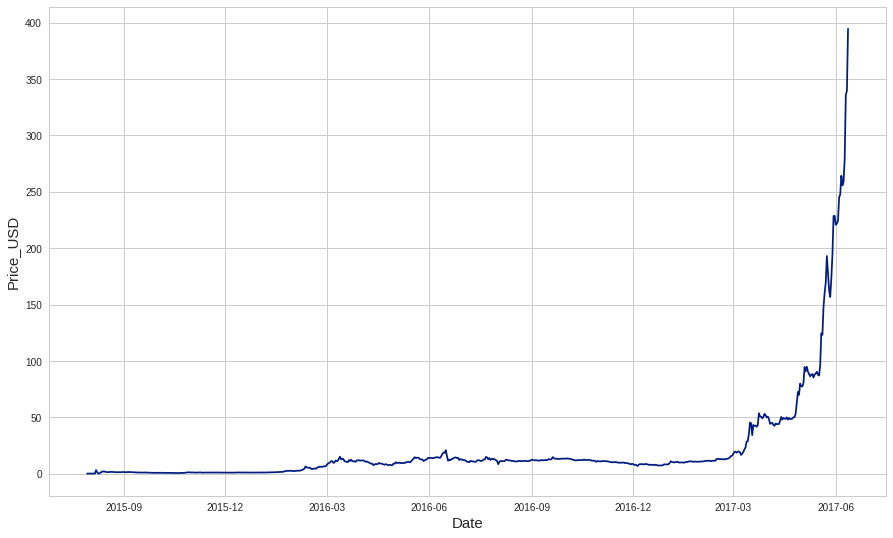

In [7]:
plt.subplots(figsize=(15, 9))
plt.plot(data['date'], data['price_USD'])
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Price_USD", fontsize = 15)

<h3> <center> Correlation plot. </center></h3>

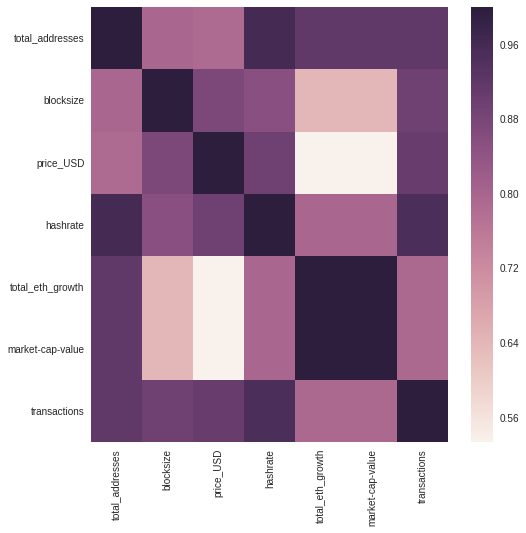

In [8]:
plt.subplots(figsize = (8, 8))
correlation_object = data.iloc[:, 1:8].corr()
sns.heatmap(correlation_object)

Let's do the analysis only on 2015, 2016. Let's put aside 2017 it will also help us as the testing set. 

In [9]:
testing_data = data.loc[data['year'] == 2017]
training_data = data.loc[data['year'] != 2017]

del data

Looking at the plot above,it looks like "Total_eth_growth" and "market_cap_value" are the same. That is correlation is 100%. <br>
Let's remove one of them. Let's remove market_cap_value. 

In [10]:
def remove_marketcapvalue():
    global testing_data, training_data
    testing_data.drop('market-cap-value', axis = 1, inplace = True)
    training_data.drop('market-cap-value', axis = 1, inplace = True)
    
remove_marketcapvalue()

training_data.head()

,timestamp,total_addresses,blocksize,price_USD,hashrate,total_eth_growth,transactions,date,year
0,1.438214e+09,9205.0,644.0,0.0,23.7569,7.204931e+07,8893.0,2015-07-30,2015
1,1.438301e+09,9361.0,582.0,0.0,48.1584,7.208550e+07,0.0,2015-07-31,2015
2,1.438387e+09,9476.0,575.0,0.0,55.2709,7.211320e+07,0.0,2015-08-01,2015
3,1.438474e+09,9563.0,581.0,0.0,64.1779,7.214143e+07,0.0,2015-08-02,2015
4,1.438560e+09,9639.0,587.0,0.0,69.8559,7.216940e+07,0.0,2015-08-03,2015


Price fluctuations excluding 2017.

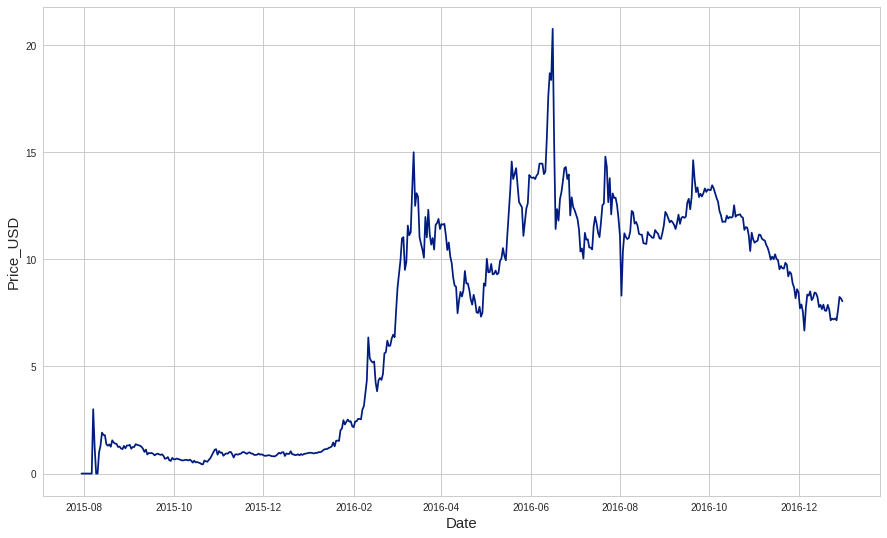

In [11]:
#Plot and remove the date column. 
plt.subplots(figsize=(15, 9))
plt.plot(training_data['date'], training_data['price_USD'])
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Price_USD", fontsize = 15)

In [12]:
def drop_date():
    global training_data, testing_data
    training_data.drop('date', inplace = True, axis = 1)
    testing_data.drop('date', inplace = True, axis = 1)
    
drop_date()
training_data.dtypes


timestamp           float64
total_addresses     float64
blocksize           float64
price_USD           float64
hashrate            float64
total_eth_growth    float64
transactions        float64
year                  int64
dtype: object

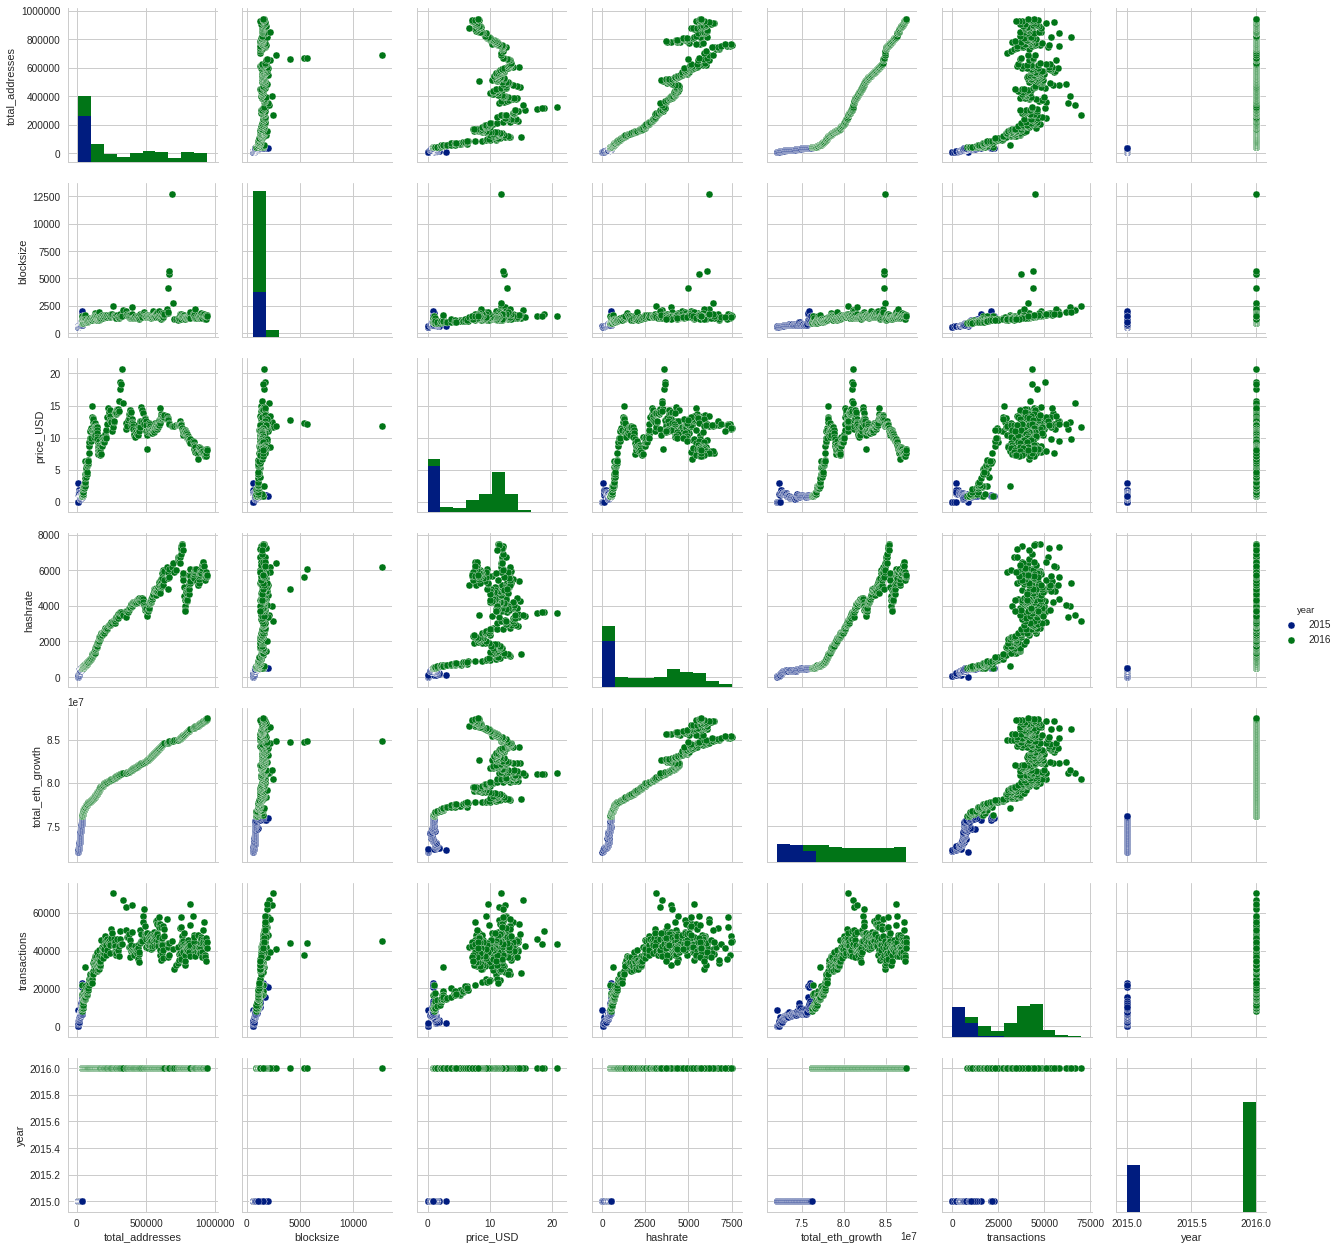

In [13]:
#what ever calculations are to be done. It's better to exclude 2017 since 2017 is not finished yet and the groupings' values might not be accurate. 
sns.pairplot(training_data.iloc[:, 1:], hue = "year")

In [14]:
#Lets come up with new features on time stamp like date, month etc. 

def date_features(dataframe):
    dataframe['day'] = dataframe.apply(lambda x: dt.datetime.fromtimestamp(x['timestamp']).day, axis = 1)
    dataframe['month'] = dataframe.apply(lambda x: dt.datetime.fromtimestamp(x['timestamp']).month, axis = 1)
    dataframe['week'] = dataframe.apply(lambda x: np.ceil(x['day']/7), axis = 1)
    return(dataframe)

training_data = date_features(training_data)
testing_data = date_features(testing_data)

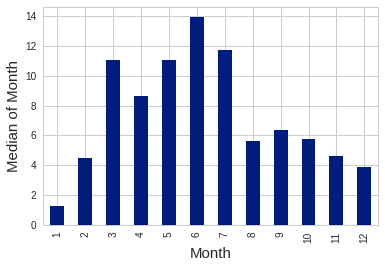

In [15]:
training_data.groupby('month')['price_USD'].median().plot(kind = 'bar')
plt.ylabel("Median of Month", fontsize = 15)
plt.xlabel("Month", fontsize = 15)

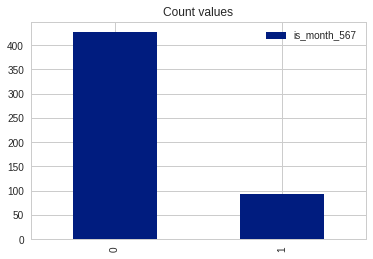

In [16]:
#Let's create a new feature which describes whether the given month is 5|6|7
def is_month_567(dataframe):
    dataframe['is_month_567'] = [1 if x in [5,6,7] else 0 for x in dataframe['month']]
    return(dataframe)

training_data = is_month_567(training_data)
testing_data = is_month_567(testing_data)

training_data['is_month_567'].value_counts().to_frame().plot(kind = "bar")
plt.title("Count values")

<h3> <center> Preparing data for modelling. </center> </h3>
From the graphs above, there seems to be a sudden upward trend from 2017. Hence there is a good chance for models to get wrong there. <br>
So our results for test set can be expected to be bad!

In [17]:
#Preparing for modelling. 
def prepare_modelling():
    global training_data, testing_data
    concat_data = pd.concat([training_data, testing_data])
    target = concat_data['price_USD']
    concat_data.drop(['timestamp', 'price_USD'], axis = 1, inplace = True)
    
    #get index of test and train sets. 
    train_index = concat_data[concat_data['year'] != 2017].index.tolist()
    test_index = list(set(train_index).symmetric_difference(set(range(len(concat_data)))))
    
    #dummify data. 
    def dummified_data(dataframe):
        dataframe = pd.concat([pd.get_dummies(dataframe['year'], prefix= 'year', prefix_sep='_').reset_index(drop = True),  dataframe.reset_index(drop = True)], axis = 1)
        dataframe = pd.concat([pd.get_dummies(dataframe['month'], prefix='month', prefix_sep='_').reset_index(drop = True),  dataframe.reset_index(drop = True)], axis = 1)
        dataframe = pd.concat([pd.get_dummies(dataframe['day'], prefix='day', prefix_sep='_').reset_index(drop = True),  dataframe.reset_index(drop = True)], axis = 1)
        dataframe = pd.concat([pd.get_dummies(dataframe['week'], prefix='week', prefix_sep='_').reset_index(drop = True),  dataframe.reset_index(drop = True)], axis = 1)
    
        r_cols = ['year', 'month', 'day', 'week']
        dataframe.drop(r_cols, axis = 1, inplace = True)
    
        return(dataframe)
    concat_data = dummified_data(concat_data)
    
    train_X = concat_data.loc[train_index]
    train_Y = target[train_index]
    
    test_X = concat_data.loc[test_index]
    test_Y = target[test_index]
    
    return(train_X, train_Y, test_X, test_Y)


train_X, train_Y, test_X, test_Y = prepare_modelling()
    

In [18]:
import xgboost as xgb

from sklearn import cross_validation, model_selection
xgbfolds = model_selection.KFold(n_splits=5)

xgb_dtrain = xgb.DMatrix(train_X, train_Y)
xgb_dtest = xgb.DMatrix(test_X)

xgb_params = {'learning_rate' : 0.03, 
             'subsample' : 0.7,
             'max_depth' : 5,
             'colsample_bytree' : 0.8,
              'objective': 'reg:linear',
              'eval_metric': 'rmse',
             'silent': 0
             }
xgb_obj = xgb.cv(params = xgb_params, dtrain = xgb_dtrain, early_stopping_rounds=10,
                       verbose_eval=True, show_stdv=False, folds = xgbfolds, num_boost_round = 9999)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:588: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


[0]	train-rmse:8.11773	test-rmse:8.11691
[1]	train-rmse:7.88284	test-rmse:7.87959
[2]	train-rmse:7.65643	test-rmse:7.65348
[3]	train-rmse:7.43599	test-rmse:7.43424
[4]	train-rmse:7.22217	test-rmse:7.21982
[5]	train-rmse:7.01492	test-rmse:7.01247
[6]	train-rmse:6.8143	test-rmse:6.81237
[7]	train-rmse:6.62073	test-rmse:6.61842
[8]	train-rmse:6.43301	test-rmse:6.43166
[9]	train-rmse:6.24937	test-rmse:6.25061
[10]	train-rmse:6.07068	test-rmse:6.07136
[11]	train-rmse:5.89894	test-rmse:5.8989
[12]	train-rmse:5.73211	test-rmse:5.73203
[13]	train-rmse:5.56941	test-rmse:5.56822
[14]	train-rmse:5.41264	test-rmse:5.41366
[15]	train-rmse:5.26032	test-rmse:5.26216
[16]	train-rmse:5.11124	test-rmse:5.11123
[17]	train-rmse:4.96659	test-rmse:4.96838
[18]	train-rmse:4.82717	test-rmse:4.83117
[19]	train-rmse:4.69201	test-rmse:4.69518
[20]	train-rmse:4.56113	test-rmse:4.5639
[21]	train-rmse:4.43443	test-rmse:4.43724
[22]	train-rmse:4.31097	test-rmse:4.31478
[23]	train-rmse:4.19148	test-rmse:4.1979
[24]	t

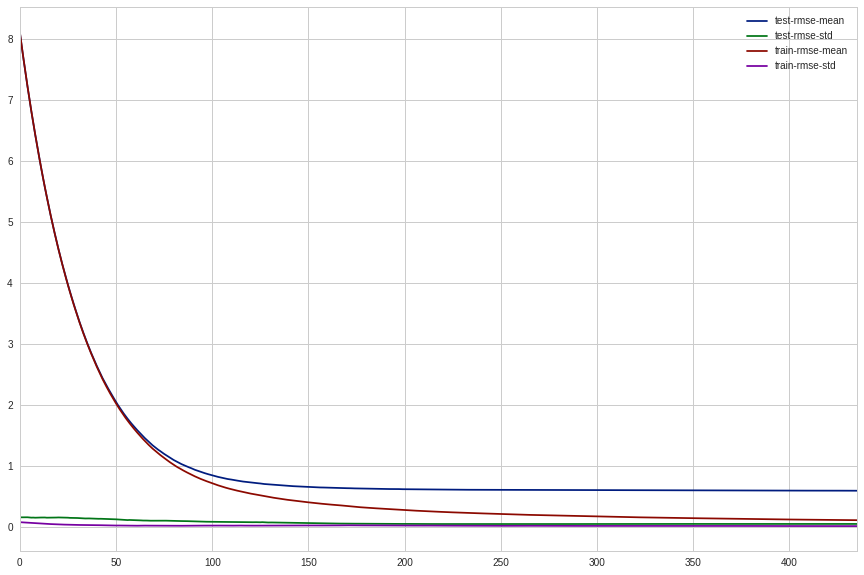

In [19]:
xgb_obj.plot(figsize = (15,10))

In [20]:
xgb = xgb.train(params = xgb_params, dtrain = xgb_dtrain, num_boost_round = 80)

predictions = xgb.predict(xgb_dtest)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_true = test_Y, y_pred = predictions)

8900.4374239783301

Like we expected, the results were as we thought they would be. This shift in trend is called <b>'Structural change'</b>. <br> You can read more about it <a href = "https://en.wikipedia.org/wiki/Structural_break"> here. </a> <br>
If you want to get better results we can consider a <b>part</b> of 2017 as test set. 

I'll leave that to you. Let me know if you get better results. 
